## Low level PyTorch interface

In [11]:
import numpy as np               # results verification during grading
import math                      # Pi

import matplotlib.pyplot as plt  # 2D plot in task 1
%matplotlib inline

import torch
assert torch.__version__ >= '1.3.0'

In [12]:
from notmnist import load_notmnist 

While learning PyTorch, you will have lots of questions, e.g.

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use etc.

To find the answers, you are expected to study [documentation](https://pytorch.org/docs/stable/index.html) and google a lot.

If this is your first PyTorch experience, you may want to [start here](https://pytorch.org/tutorials/).

Quick documentation on functions and modules is available with `?` and `help()`, like so:

## Task 

You have to solve yet another character recognition problem: *notMNIST* dataset of 10 letters and ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% validation accuracy,
2. at least 2 linear layers,
3. no convolutions,
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

Tips:

* Don't use the structures from homework 1 (`Sequential`, `.forward()` etc.). I suggest that your `NeuralNet.predict()` consists of 5-7 lines.
* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

Happy googling!

In [13]:
letters = 'ABCDEFGHIJ'
X_train, y_train, X_val, y_val = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_val.squeeze_();

Parsing... (it's OK if <10 images are broken)
Found broken image: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Found broken image: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


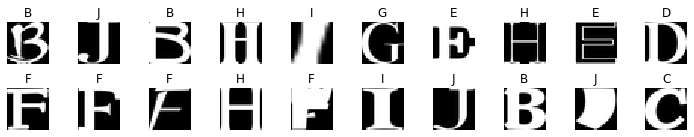

In [14]:
fig, axarr = plt.subplots(2, 10, figsize=(10, 2))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

fig.tight_layout()

In [15]:
np.random.seed(666)
torch.manual_seed(666)

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [20]:
class NeuralNet:
    EPS = 0.01
    LR = 0.1

    def __init__(self):
        self.linear1 = torch.randn((28*28, 28*28//2)) * self.EPS
        self.bias1 = torch.randn(28*28//2) * self.EPS
        self.linear2 = torch.randn((28*28//2, 10)) * self.EPS
        self.bias2 = torch.randn(10) * self.EPS

        self.linear1.requires_grad_()
        self.bias1.requires_grad_()
        self.linear2.requires_grad_()
        self.bias2.requires_grad_()

    def predict(self, images):
        """
        images:
            `torch.tensor`, shape == `batch_size x height x width`, dtype == `torch.float32`
            A minibatch of images -- the input to the neural net.
        
        return:
        prediction:
            `torch.tensor`, shape == `batch_size x 10`, dtype == `torch.float32`
            The probabilities of each input image to belong to each of the dataset classes.
            Namely, `output[i, j]` is the probability of `i`-th
            minibatch sample to belong to `j`-th class.
        """
        batch_size = images.shape[0]
        out1 = images.reshape(batch_size, -1)
        out2 = out1 @ self.linear1 + self.bias1
        out3 = out2.sigmoid()
        out4 = out3 @ self.linear2 + self.bias2
        out5 = out4.softmax(dim=1)
        return out5

    def do_gradient_step(self):
        self.linear1.data = self.linear1.data - self.LR * self.linear1.grad.detach()
        self.bias1.data = self.bias1.data - self.LR * self.bias1.grad.detach()
        self.linear2.data = self.linear2.data - self.LR * self.linear2.grad.detach()
        self.bias2.data = self.bias2.data - self.LR * self.bias2.grad.detach()

        self.linear1.grad.zero_()
        self.bias1.grad.zero_()
        self.linear2.grad.zero_()
        self.bias2.grad.zero_()
    

In [21]:
def accuracy(model, images, labels):
    """
    model:
        `NeuralNet`
    images:
        `torch.tensor`, shape == `N x height x width`, dtype == `torch.float32`
    labels:
        `torch.tensor`, shape == `N`, dtype == `torch.int64`
        Class indices for each sample in `images`.
    
    return:
    value:
        `float`
        The fraction of samples from `images` correctly classified by `model`.
        `0 <= value <= 1`.
        
    """
    with torch.no_grad():
        probs = model.predict(images)
    preds = torch.argmax(probs, dim=1)
    return torch.sum(preds == labels).item() / labels.shape[0]

In [22]:
model = NeuralNet()
batch_size = 128
epochs = 6

In [23]:
%%time
torch.set_num_threads(1)

for k in range(epochs):
    print('{} epoch has started'.format(k + 1))

    idxs = torch.randperm(X_train.shape[0])
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    for i in range(0, X_train.shape[0], batch_size):
        X_train_batch, y_train_batch = X_train[i: i + batch_size], y_train[i: i + batch_size]
        preds = model.predict(X_train_batch)
        loss = -torch.mean(torch.log(torch.gather(preds, 1, y_train_batch.unsqueeze(1)).squeeze()))
        loss.backward()
        model.do_gradient_step()

1 epoch has started
2 epoch has started
3 epoch has started
4 epoch has started
5 epoch has started
6 epoch has started
CPU times: user 4.5 s, sys: 577 ms, total: 5.07 s
Wall time: 7.61 s


In [24]:
train_accuracy = accuracy(model, X_train, y_train) * 100
val_accuracy = accuracy(model, X_val, y_val) * 100
print("Training accuracy: %.2f, validation accuracy: %.2f" % (train_accuracy, val_accuracy))

assert val_accuracy >= 82.0
print("Well done!")

Training accuracy: 89.41, validation accuracy: 88.70
Well done!
